# DoubleGlovo: Analysis v3

This document walks throught the full DoubleGlovo analysis from intro to final conclusions

### Imports

In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

sys.path.append('c:\\Users\\Jordi Cremades\\Documents\\Repository')

from Utilities import query_engines

### Business questions we want to answer

All answers want to be answered taking into account: 
- Is the customer new in Groceries
- Is the customer Prime
- Is the session DG or not DG

Ticket 1:
- [ ] What is the time difference between placing a Food order and a Groceries order? 
- [ ] What % of food orders lead to groceries order?
- [ ] What percentage of users saw the DG advert and did not convert?

Ticket 2:
- [ ] What is the groceries order incrementaly in the next 15 days?
- [ ] What is the incrementality in AOV in the next 15 days?
- [ ] What is the AOV difference of DG vs not DG?
- [ ] What is the impact on retention?

Ticket 3:
- [ ] What is the final conclusion on DG having 1.68 more orders in the same months
- [ ] What is the final conclusion on DG reporting 1.78 more orders in the following 28 days
- [ ] How do points 1 and 2 differ if (i) Zero inflated Possion, (ii) Delete zeros

Extra:
- [X] How many NC come from DG compared to not DG
- [X] How many DG users are recurrent
- [ ] How does NC new users accelerate compared to RC
- [ ] How does GMV for RC evolve
- [ ] What would be the final conclusions at a GMV level  
 

### Data Loading

In [172]:
query = query_engines.QueryEngines(
    query='v3/orders_created.sql', 
    del1='--v1', 
    del2='--endv1',
    params=None,
    load_from_output_file='orders_created_v3',
    output_file='orders_created_v3',
    printq=None
)

df = query.query_run_starbust()

### Data Cleaning

In [7]:
# Dataframe formating

# Delete any nulls rows
df.dropna(subset=['customer_id', 'store_accessed_channel','months_old'], inplace=True) 

# Convert columns
df['customer_id'] = df['customer_id'].astype(int)
df['p_creation_date'] = pd.to_datetime(df['p_creation_date'])

# Create new treatment
df['treatment'] =  np.where(df['store_accessed_channel']=='DoubleGlovo', True, False)

# Drop duplicates
df.drop_duplicates(subset='order_id',keep=False,inplace=True)

In [5]:
df.isnull().sum()

p_creation_date                    0
order_id                           0
country                            0
store_id                           0
order_subvertical2                 0
store_accessed_channel             0
customer_id                        0
user_is_prime                      0
user_is_GNC                        0
months_old                         0
aov_groceries_preceding30d         0
aov_groceries_next30d              0
gmv_groceries_preceding30d         0
gmv_groceries_next30d              0
n_groceries_orders_preceding30d    0
n_groceries_orders_next30d         0
n_groceries_orders_next28d         0
treatment                          0
dtype: int64

Data Cleaning final summary

In [8]:
# Summary df
print('There are {} rows in the dataframe'.format(len(df)))
print('There are {} distinct orders'.format(df['order_id'].nunique()))
print('Min Date = {}'.format(df['p_creation_date'].min()))
print('Max Date = {}'.format(df['p_creation_date'].max()))
difference_days = df['p_creation_date'].max()-df['p_creation_date'].min()
print('Difference days: {}'.format(difference_days.days))

There are 8767009 rows in the dataframe
There are 8767009 distinct orders
Min Date = 2023-07-13 00:00:00
Max Date = 2023-11-09 00:00:00
Difference days: 119


### Data exploration

Q: How many Groceries orders are DoubleGlovo?

A: 0.17%

In [10]:
store_accessed_channel_counts = df[df['order_subvertical2']=='Groceries']['store_accessed_channel'].value_counts()
store_accessed_channel_perc = store_accessed_channel_counts/len(df)*100
print(store_accessed_channel_perc)

store_accessed_channel
NotDoubleGlovo    99.83009
DoubleGlovo        0.16991
Name: count, dtype: float64


Q: How many orders are NC vs RC?

A: 10% of the ordres are NC orders, and 90% RC orders. Representing 930K and 7.8M ordres respectively

In [80]:
df['user_is_GNC'].value_counts(normalize=True)*100

user_is_GNC
False    89.372487
True     10.627513
Name: proportion, dtype: float64

In [81]:
df['user_is_GNC'].value_counts()

user_is_GNC
False    7835294
True      931715
Name: count, dtype: int64

Q: How many NC come from DG compared to not DG?

A: 0.54% NC come from DG. In raw numbers ~5K new users

In [18]:
cond = df['user_is_GNC'] == True

df[cond]['store_accessed_channel'].value_counts(normalize=True)*100

store_accessed_channel
NotDoubleGlovo    99.453374
DoubleGlovo        0.546626
Name: proportion, dtype: float64

Q: How many customers repeated DoubleGlovo?

A: There are ~1.9M distinct customers, ~14K customers used DG --> (12.9K only one time, which represents 93% of the sample)

In [41]:
# How many customers
df['customer_id'].nunique()

# How many distinct customers used DG
cond = df['store_accessed_channel'] =='DoubleGlovo'
df[cond]['customer_id'].nunique()

# What is the distribution of DG in the DG users
cond = df['store_accessed_channel'] =='DoubleGlovo'

bins_size = 1 # Param

customer_id_counts = df[cond].groupby('customer_id').size()
bins_num = int((customer_id_counts.max() - customer_id_counts.min())/bins_size)
hist, bin_edges = np.histogram(customer_id_counts, bins=bins_num) # Histogram values
bin_ranges = [f"[{round(bin_edges[i], 2)} - {round(bin_edges[i+1], 2)}]" for i in range(len(bin_edges) - 1)] # Format the bins
percentages = hist / len(customer_id_counts) * 100 # Compute the % that represents each bin

hist_df = pd.DataFrame({
    'bin_edges': bin_ranges
    ,'n_hist': hist
    ,'percentage': percentages
    }) # Save data in a df

hist_df

,bin_edges,n_hist,percentage
0,[1.0 - 2.0],12905,93.779522
1,[2.0 - 3.0],677,4.919701
2,[3.0 - 4.0],123,0.893830
3,[4.0 - 5.0],35,0.254342
4,[5.0 - 6.0],13,0.094470
5,[6.0 - 7.0],3,0.021801
6,[7.0 - 8.0],1,0.007267
7,[8.0 - 9.0],1,0.007267
8,[9.0 - 10.0],1,0.007267
9,[10.0 - 11.0],2,0.014534


Q: What is the distribution of customers and orders?

A: 
- 50% of customers = 1 order
- 90% of customers <= 10 orders


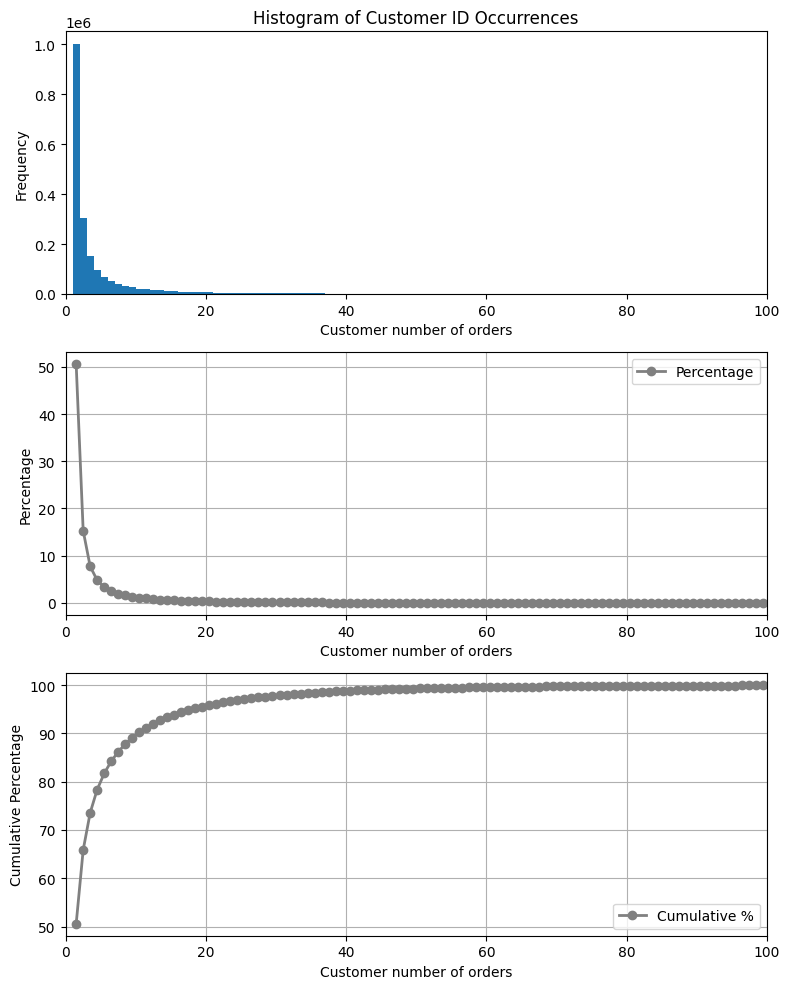

In [26]:
#params
bins_size = 1

plt.figure(figsize=(8, 10))

# Histogram
plt.subplot(3, 1, 1)
customer_id_counts = df.groupby('customer_id').size()
bins_num = int((customer_id_counts.max() - customer_id_counts.min())/bins_size)
plt.hist(customer_id_counts, bins=bins_num)
plt.xlabel('Customer number of orders')
plt.ylabel('Frequency')
plt.title('Histogram of Customer ID Occurrences')
plt.xlim(0, 100)
plt.grid(False)

# % distribution
plt.subplot(3, 1, 2)
hist, bins = np.histogram(customer_id_counts, bins=bins_num)
total_customers = len(customer_id_counts)
percentages = [(count / total_customers) * 100 for count in hist]
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.plot(bin_centers, percentages, '-o', color='grey', linewidth=2, label='Percentage')
plt.xlabel('Customer number of orders')
plt.ylabel('Percentage')
plt.xlim(0, 100)
plt.grid(True)
plt.legend()

# % Cumulative percentages
plt.subplot(3, 1, 3)
cumulative_percentage = np.cumsum(percentages)
plt.plot(bin_centers, cumulative_percentage, '-o', color='grey', linewidth=2, label='Cumulative %')
plt.xlabel('Customer number of orders')
plt.ylabel('Cumulative Percentage')
plt.xlim(0, 100)
plt.grid(True)
plt.legend()


plt.tight_layout()  # Adjusts the subplots to avoid overlapping
plt.show()


In [7]:
# We will split the analysis
customer_id_counts = df.groupby('customer_id').size()
series_lte_10 = customer_id_counts[customer_id_counts <= 10]
series_gt_10 = customer_id_counts[customer_id_counts > 10]

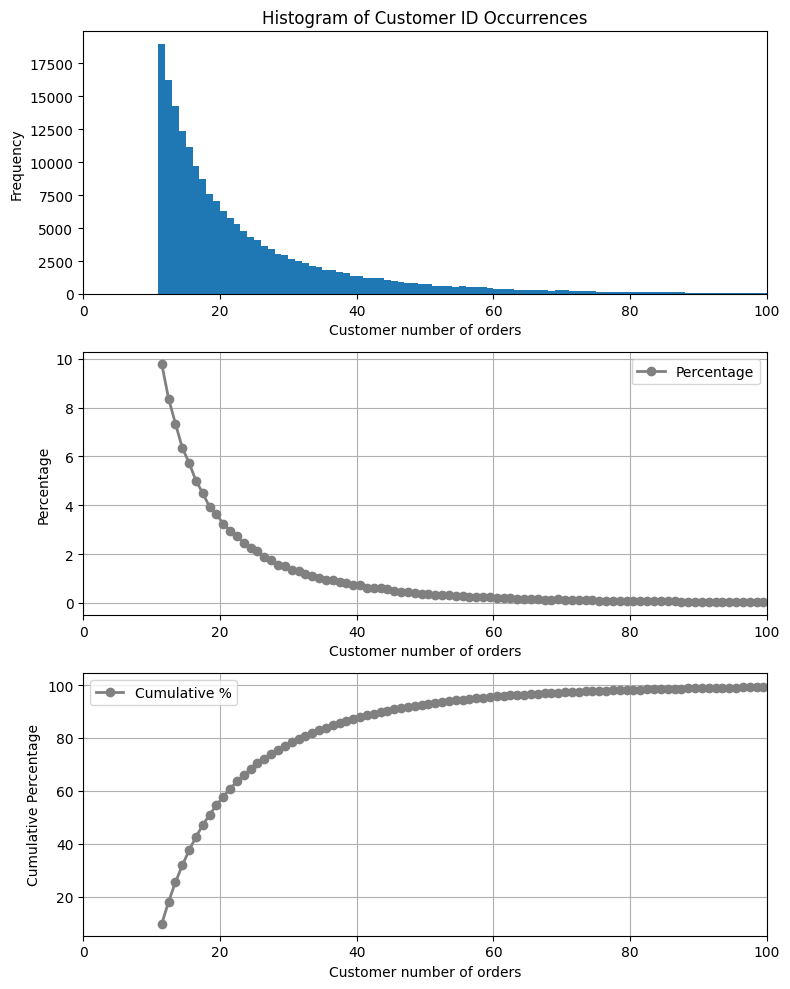

In [8]:
#Behavior of customers less or equal to 10 orders

#params
bins_size = 1
cond = df['customer_id'].isin(series_gt_10.index)

plt.figure(figsize=(8, 10))

# Histogram
plt.subplot(3, 1, 1)
customer_id_counts = df[cond].groupby('customer_id').size()
bins_num = int((customer_id_counts.max() - customer_id_counts.min())/bins_size)
plt.hist(customer_id_counts, bins=bins_num)
plt.xlabel('Customer number of orders')
plt.ylabel('Frequency')
plt.title('Histogram of Customer ID Occurrences')
plt.xlim(0, 100)
plt.grid(False)

# % distribution
plt.subplot(3, 1, 2)
hist, bins = np.histogram(customer_id_counts, bins=bins_num)
total_customers = len(customer_id_counts)
percentages = [(count / total_customers) * 100 for count in hist]
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.plot(bin_centers, percentages, '-o', color='grey', linewidth=2, label='Percentage')
plt.xlabel('Customer number of orders')
plt.ylabel('Percentage')
plt.xlim(0, 100)
plt.grid(True)
plt.legend()

# % Cumulative percentages
plt.subplot(3, 1, 3)
cumulative_percentage = np.cumsum(percentages)
plt.plot(bin_centers, cumulative_percentage, '-o', color='grey', linewidth=2, label='Cumulative %')
plt.xlabel('Customer number of orders')
plt.ylabel('Cumulative Percentage')
plt.xlim(0, 100)
plt.grid(True)
plt.legend()


plt.tight_layout()  # Adjusts the subplots to avoid overlapping
plt.show()


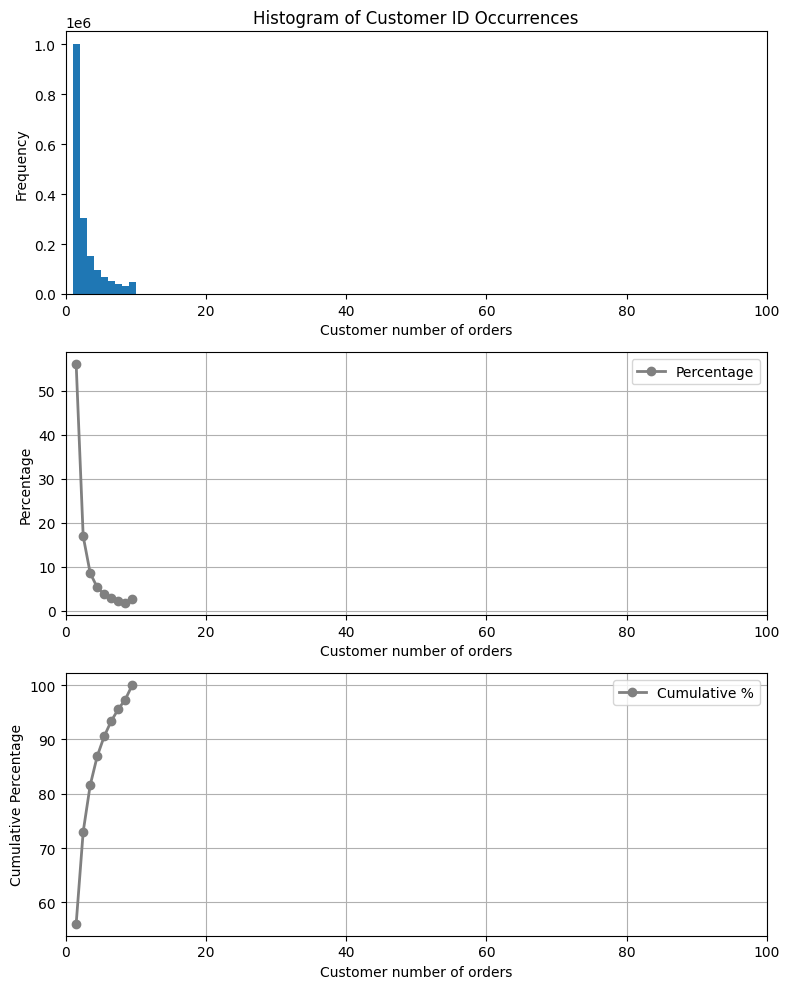

In [9]:
#Behavior of customers greater than 10 orders

#params
bins_size = 1
cond = df['customer_id'].isin(series_lte_10.index)

plt.figure(figsize=(8, 10))

# Histogram
plt.subplot(3, 1, 1)
customer_id_counts = df[cond].groupby('customer_id').size()
bins_num = int((customer_id_counts.max() - customer_id_counts.min())/bins_size)
plt.hist(customer_id_counts, bins=bins_num)
plt.xlabel('Customer number of orders')
plt.ylabel('Frequency')
plt.title('Histogram of Customer ID Occurrences')
plt.xlim(0, 100)
plt.grid(False)

# % distribution
plt.subplot(3, 1, 2)
hist, bins = np.histogram(customer_id_counts, bins=bins_num)
total_customers = len(customer_id_counts)
percentages = [(count / total_customers) * 100 for count in hist]
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.plot(bin_centers, percentages, '-o', color='grey', linewidth=2, label='Percentage')
plt.xlabel('Customer number of orders')
plt.ylabel('Percentage')
plt.xlim(0, 100)
plt.grid(True)
plt.legend()

# % Cumulative percentages
plt.subplot(3, 1, 3)
cumulative_percentage = np.cumsum(percentages)
plt.plot(bin_centers, cumulative_percentage, '-o', color='grey', linewidth=2, label='Cumulative %')
plt.xlabel('Customer number of orders')
plt.ylabel('Cumulative Percentage')
plt.xlim(0, 100)
plt.grid(True)
plt.legend()


plt.tight_layout()  # Adjusts the subplots to avoid overlapping
plt.show()


### Incrementality

Q: What is the AMORU incrementality?

A1: There are 1.9M distinct customers in the dataset, from which 1.1M where RC during the full period and 886K where GNC at some point

A2: For all countries. For a given order, the following 30d there are less orders. Does not matter if the customer is GRC during the whole period or if at some point it was GNC. (Positive means that DG leads to more orders)

In [171]:
df_or.order_id.value_counts()

order_id
707161586    1
707666370    1
707999554    1
694790772    1
724729459    1
            ..
683846113    1
683898405    1
677183553    1
677149710    1
677509191    1
Name: count, Length: 8767009, dtype: int64

In [134]:
df_or = df.copy()


In [159]:
df = df.groupby(['customer_id','treatment']).sample(1)

In [160]:
print(df.shape)

(1982061, 18)


In [161]:
print(df_or.shape)

(8767009, 18)


In [163]:
pd.crosstab(df.treatment,df.country)

country,AM,BA,CI,ES,GE,GH,HR,IT,KE,KG,...,MA,ME,NG,PL,PT,RO,RS,SI,UA,UG
treatment,,,,,,,,,,,,,,,,,,,,,
False,4388,4627,27972,491348,76184,8331,33008,195498,46993,16470,...,145706,8771,18805,224402,141045,230988,38296,1926,215465,5640
True,25,36,111,1404,155,98,315,438,102,168,...,501,44,176,570,402,326,22,20,1416,0


In [164]:
pd.crosstab(df_or.treatment,df_or.country)

country,AM,BA,CI,ES,GE,GH,HR,IT,KE,KG,...,MA,ME,NG,PL,PT,RO,RS,SI,UA,UG
treatment,,,,,,,,,,,,,,,,,,,,,
False,12961,10964,156864,2122175,391338,27362,88871,627005,283568,52410,...,918608,43216,63717,861154,581378,1264691,148919,4271,924828,19688
True,48,51,289,3918,341,153,516,929,310,237,...,1560,107,317,1075,1132,911,35,27,2405,1


In [165]:
cond = df['user_is_GNC'] == True
customers_GNC_at_some_point = df[cond]['customer_id'].unique()
cond = ~df['customer_id'].isin(customers_GNC_at_some_point)
customers_GRC_all_period = df[cond]['customer_id'].unique()

In [166]:
# Customers that were GNC at some point
cond = df['customer_id'].isin(customers_GNC_at_some_point)


dfg = df[cond].groupby(['country', 'treatment']).agg({'n_groceries_orders_next30d': 'mean', 'order_id': 'count'}).reset_index()
dfg.columns = ['country', 'treatment', 'mean_groceries_orders_next30d', 'n_orders']

pivot_table = dfg.pivot(index='country', columns='treatment', values=['mean_groceries_orders_next30d', 'n_orders'])
pivot_table['relative_difference'] = (pivot_table[('mean_groceries_orders_next30d', True)] - pivot_table[('mean_groceries_orders_next30d', False)]) / pivot_table[('mean_groceries_orders_next30d', False)]*100

pivot_table_backup_GNC_at_some_point = pivot_table.copy()
pivot_table

mean_groceries_orders_next30d            n_orders          \
treatment                         False      True     False    True   
country                                                               
AM                             0.302335  0.222222    2570.0    18.0   
BA                             0.175486  0.093750    2570.0    32.0   
CI                             0.355689  0.435484    8305.0    62.0   
ES                             0.212640  0.276316  164254.0   684.0   
GE                             0.244239  0.198020   25692.0   101.0   
GH                             0.275180  0.273973    3743.0    73.0   
HR                             0.183124  0.113208   14482.0   212.0   
IT                             0.235653  0.204000   80067.0   250.0   
KE                             0.371161  0.192982   14654.0    57.0   
KG                             0.211633  0.086667    8992.0   150.0   
KZ                             0.227980  0.365979   18449.0   194.0   
MA                             0.309058  0.234568   44160.0   243.0   
ME                             0.318358  0.230769    3094.0    26.0   
NG                             0.370741  0.241379   10390.0   145.0   
PL                             0.275858  0.192214   85700.0   411.0   
PT                             0.233494  0.172414   54875.0   232.0   
RO                             0.228233  0.197531   78262.0   162.0   
RS                             0.214593  0.428571   14418.0    14.0   
SI                             0.153846  0.125000    1079.0    16.0   
UA                             0.258379  0.228739   85007.0  1023.0   
UG                             0.322119       NaN    2586.0     NaN   

          relative_difference  
treatment                      
country                        
AM                 -26.497926  
BA                 -46.577051  
CI                  22.433769  
ES                  29.945239  
GE                 -18.923908  
GH                  -0.438888  
HR                 -38.179800  
IT                 -13.431906  
KE                 -48.005793  
KG                 -59.048520  
KZ                  60.531470  
MA                 -24.102297  
ME                 -27.512690  
NG                 -34.892756  
PL                 -30.321266  
PT                 -26.159316  
RO                 -13.452242  
RS                  99.713732  
SI                 -18.750000  
UA                 -11.471424  
UG                        NaN

In [167]:
# Customers that were GRC during the whole period
cond = df['customer_id'].isin(customers_GRC_all_period)
df_study = df[cond]

dfg = df_study.groupby(['country', 'treatment']).agg({'n_groceries_orders_next30d': 'mean', 'order_id': 'count'}).reset_index()
dfg.columns = ['country', 'treatment', 'mean_groceries_orders_next30d', 'n_orders']

pivot_table = dfg.pivot(index='country', columns='treatment', values=['mean_groceries_orders_next30d', 'n_orders'])
pivot_table['relative_difference'] = (pivot_table[('mean_groceries_orders_next30d', True)] - pivot_table[('mean_groceries_orders_next30d', False)]) / pivot_table[('mean_groceries_orders_next30d', False)]*100

pivot_table_backup_GRC = pivot_table.copy()
pivot_table

mean_groceries_orders_next30d            n_orders         \
treatment                         False      True     False   True   
country                                                              
AM                             1.766227  2.000000    1818.0    7.0   
BA                             0.951872  0.500000    2057.0    4.0   
CI                             2.192963  1.755102   19667.0   49.0   
ES                             1.569041  1.243056  327094.0  720.0   
GE                             2.030678  1.000000   50492.0   54.0   
GH                             1.321927  1.000000    4588.0   25.0   
HR                             1.003778  0.660194   18526.0  103.0   
IT                             1.250210  0.776596  115431.0  188.0   
KE                             2.396333  2.755556   32339.0   45.0   
KG                             1.677320  0.500000    7478.0   18.0   
KZ                             1.685329  1.010417   21130.0   96.0   
MA                             2.376746  1.500000  101546.0  258.0   
ME                             1.939581  1.388889    5677.0   18.0   
NG                             1.851456  0.903226    8415.0   31.0   
PL                             1.573243  0.792453  138702.0  159.0   
PT                             1.619763  1.529412   86170.0  170.0   
RO                             2.162978  1.274390  152726.0  164.0   
RS                             1.487269  0.500000   23878.0    8.0   
SI                             0.831169  0.500000     847.0    4.0   
UA                             1.783149  0.783715  130458.0  393.0   
UG                             1.543877       NaN    3054.0    NaN   

          relative_difference  
treatment                      
country                        
AM                  13.235752  
BA                 -47.471910  
CI                 -19.966631  
ES                 -20.776111  
GE                 -50.755367  
GH                 -24.352844  
HR                 -34.229096  
IT                 -37.882780  
KE                  14.990530  
KG                 -70.190545  
KZ                 -40.046322  
MA                 -36.888489  
ME                 -28.392315  
NG                 -51.215371  
PL                 -49.629355  
PT                  -5.578068  
RO                 -41.081686  
RS                 -66.381325  
SI                 -39.843750  
UA                 -56.048811  
UG                        NaN

Q: What is the AMORU incrementality only for the first order of a GNC?

A1: For some countries. For a given order, the following 30d there are less orders if its a DG order. For some others not. (Positive means that DG leads to more orders)

A2: If we compare the relative difference of the First Orders vs (i) All GRC ordres and (ii) All ordres from customers that where GNC at some point. We see that the first orders that come from DG lead to more orders in most countries in the following 30d

In [170]:
# Customers that were GRC during the whole period
cond = df['user_is_GNC'] == True
df_study = df[cond]

dfg = df_study.groupby(['country', 'treatment']).agg({'n_groceries_orders_next30d': 'mean', 'order_id': 'count'}).reset_index()
dfg.columns = ['country', 'treatment', 'mean_groceries_orders_next30d', 'n_orders']

pivot_table = dfg.pivot(index='country', columns='treatment', values=['mean_groceries_orders_next30d', 'n_orders'])
pivot_table['relative_difference'] = (pivot_table[('mean_groceries_orders_next30d', True)] - pivot_table[('mean_groceries_orders_next30d', False)]) / pivot_table[('mean_groceries_orders_next30d', False)]*100

pivot_table_backup_first_orders = pivot_table.copy()
pivot_table

mean_groceries_orders_next30d            n_orders          \
treatment                         False      True     False    True   
country                                                               
AM                             0.302335  0.222222    2570.0    18.0   
BA                             0.175486  0.093750    2570.0    32.0   
CI                             0.355689  0.435484    8305.0    62.0   
ES                             0.212640  0.276316  164254.0   684.0   
GE                             0.244239  0.198020   25692.0   101.0   
GH                             0.275180  0.273973    3743.0    73.0   
HR                             0.183124  0.113208   14482.0   212.0   
IT                             0.235653  0.204000   80067.0   250.0   
KE                             0.371161  0.192982   14654.0    57.0   
KG                             0.211633  0.086667    8992.0   150.0   
KZ                             0.227980  0.365979   18449.0   194.0   
MA                             0.309058  0.234568   44160.0   243.0   
ME                             0.318358  0.230769    3094.0    26.0   
NG                             0.370741  0.241379   10390.0   145.0   
PL                             0.275858  0.192214   85700.0   411.0   
PT                             0.233494  0.172414   54875.0   232.0   
RO                             0.228233  0.197531   78262.0   162.0   
RS                             0.214593  0.428571   14418.0    14.0   
SI                             0.153846  0.125000    1079.0    16.0   
UA                             0.258379  0.228739   85007.0  1023.0   
UG                             0.322119       NaN    2586.0     NaN   

          relative_difference  
treatment                      
country                        
AM                 -26.497926  
BA                 -46.577051  
CI                  22.433769  
ES                  29.945239  
GE                 -18.923908  
GH                  -0.438888  
HR                 -38.179800  
IT                 -13.431906  
KE                 -48.005793  
KG                 -59.048520  
KZ                  60.531470  
MA                 -24.102297  
ME                 -27.512690  
NG                 -34.892756  
PL                 -30.321266  
PT                 -26.159316  
RO                 -13.452242  
RS                  99.713732  
SI                 -18.750000  
UA                 -11.471424  
UG                        NaN

In [169]:
relative_diff_GNC_at_some_point = pivot_table_backup_GNC_at_some_point['relative_difference'].reset_index()
relative_diff_GRC = pivot_table_backup_GRC['relative_difference'].reset_index()
relative_diff_first_order = pivot_table_backup_first_orders['relative_difference'].reset_index()

df_merged = pd.merge(relative_diff_GNC_at_some_point,relative_diff_GRC, on='country',suffixes=('_GNC_at_some_point','_GRC'))
df_merged = pd.merge(df_merged,relative_diff_first_order, on='country',suffixes=('',''))
df_merged['diff_GNC_first_order'] = df_merged['relative_difference_GNC_at_some_point'] < df_merged['relative_difference']
df_merged['diff_GRC_first_order'] = df_merged['relative_difference_GRC'] < df_merged['relative_difference']
df_merged[['country','diff_GNC_first_order','diff_GRC_first_order']]

,country,diff_GNC_first_order,diff_GRC_first_order
0,AM,False,False
1,BA,False,True
2,CI,False,True
3,ES,False,True
4,GE,False,True
5,GH,False,True
6,HR,False,False
7,IT,False,True
8,KE,False,False
9,KG,False,True


Q: (Previous 2 questions but deleting orders that lead to 0 ordres in the following 30 days)

A:

In [132]:
cond = df['user_is_GNC'] == True
cond2 = df['n_groceries_orders_next30d']>0
customers_GNC_at_some_point = df[cond&cond2]['customer_id'].unique()
cond = ~df['customer_id'].isin(customers_GNC_at_some_point)
cond2 = df['n_groceries_orders_next30d']>0
customers_GRC_all_period = df[cond&cond2]['customer_id'].unique()

In [175]:
# Customers that were GNC at some point
cond = df['customer_id'].isin(customers_GNC_at_some_point)


dfg = df[cond].groupby(['country', 'treatment']).agg({'n_groceries_orders_next30d': 'mean', 'order_id': 'count'}).reset_index()
dfg.columns = ['country', 'treatment', 'mean_groceries_orders_next30d', 'n_orders']

pivot_table = dfg.pivot(index='country', columns='treatment', values=['mean_groceries_orders_next30d', 'n_orders'])
pivot_table['relative_difference'] = (pivot_table[('mean_groceries_orders_next30d', True)] - pivot_table[('mean_groceries_orders_next30d', False)]) / pivot_table[('mean_groceries_orders_next30d', False)]*100

pivot_table_backup_GNC_at_some_point = pivot_table.copy()
pivot_table

mean_groceries_orders_next30d            n_orders          \
treatment                         False      True     False    True   
country                                                               
AM                             0.302335  0.222222    2570.0    18.0   
BA                             0.175486  0.093750    2570.0    32.0   
CI                             0.355689  0.435484    8305.0    62.0   
ES                             0.212640  0.276316  164254.0   684.0   
GE                             0.244239  0.198020   25692.0   101.0   
GH                             0.275180  0.273973    3743.0    73.0   
HR                             0.183124  0.113208   14482.0   212.0   
IT                             0.235653  0.204000   80067.0   250.0   
KE                             0.371161  0.192982   14654.0    57.0   
KG                             0.211633  0.086667    8992.0   150.0   
KZ                             0.227980  0.365979   18449.0   194.0   
MA                             0.309058  0.234568   44160.0   243.0   
ME                             0.318358  0.230769    3094.0    26.0   
NG                             0.370741  0.241379   10390.0   145.0   
PL                             0.275858  0.192214   85700.0   411.0   
PT                             0.233494  0.172414   54875.0   232.0   
RO                             0.228233  0.197531   78262.0   162.0   
RS                             0.214593  0.428571   14418.0    14.0   
SI                             0.153846  0.125000    1079.0    16.0   
UA                             0.258379  0.228739   85007.0  1023.0   
UG                             0.322119       NaN    2586.0     NaN   

          relative_difference  
treatment                      
country                        
AM                 -26.497926  
BA                 -46.577051  
CI                  22.433769  
ES                  29.945239  
GE                 -18.923908  
GH                  -0.438888  
HR                 -38.179800  
IT                 -13.431906  
KE                 -48.005793  
KG                 -59.048520  
KZ                  60.531470  
MA                 -24.102297  
ME                 -27.512690  
NG                 -34.892756  
PL                 -30.321266  
PT                 -26.159316  
RO                 -13.452242  
RS                  99.713732  
SI                 -18.750000  
UA                 -11.471424  
UG                        NaN